# Linear Regression

![x](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L05/code/figures/adaline-concept.png?raw=true)

[stat453-deep-learning-ss21](https://github.com/rasbt/stat453-deep-learning-ss21/tree/main/L05/code)

## Imports

In [18]:
import torch 
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from torch.autograd import grad
# import seaborn as sns

torch.__version__

'1.7.1'

## Loading dataset

In [3]:
dataset_name = "./lin_reg.csv"
dataset = pd.read_csv(dataset_name)
dataset = dataset[["x1", "x2", "y"]]
dataset.head()

,x1,x2,y
0,-2.201441,-0.468864,-30.355617
1,-0.291041,0.777277,25.560334
2,-0.327755,0.040071,32.797526
3,-0.075650,1.821915,72.734577
4,-0.862493,-0.467493,-48.072356


### X and Y from dataset

In [4]:
X = torch.tensor(np.array(dataset[["x1", "x2"]]))
Y = torch.tensor(np.array(dataset[["y"]]))
print(X.shape)
print(Y.shape)

torch.Size([1000, 2])
torch.Size([1000, 1])


### 70% split

In [5]:
# random.seed(123)
torch.manual_seed(42)
shuffle_idx = torch.randperm(Y.shape[0])
shuffle_idx[:10]

tensor([542, 618, 816,  68,  94, 215,  60, 585, 942, 165])

In [6]:
split_idx = int(0.7 * (Y.shape[0]))
split_idx

700

In [7]:
x_train, x_test = X[shuffle_idx[:split_idx]], X[shuffle_idx[split_idx:]]
y_train, y_test = Y[shuffle_idx[:split_idx]], Y[shuffle_idx[split_idx:]]

### Normalize the data

In [8]:

# Normalize (mean zero, unit variance)

mu, sigma = x_train.mean(dim=0), x_train.std(dim=0)
x_train = (x_train - mu) / sigma
x_test = (x_test - mu) / sigma

### Plotting the data points

In [9]:
y_train.numpy().shape

(700, 1)

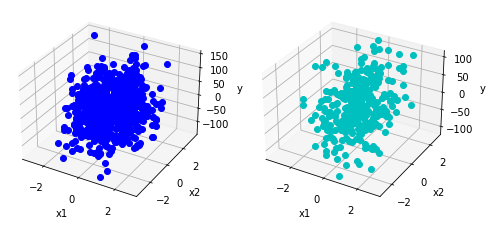

In [57]:
%matplotlib inline 
# for interactive plot use widget
#%matplotlib widget


# sns.set_style("whitegrid", {'axes.grid' : False})

colors=['b', 'c', 'y', 'm', 'r']

fig, axs = plt.subplots(1,2,figsize=(8,4), subplot_kw={'projection': '3d'})

axs[0].plot(x_train[:,0].numpy(), x_train[:,1].numpy(),y_train[:,0].numpy(), 'o', color='b')

axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].set_zlabel('y')

axs[1].plot(x_test[:,0].numpy(), x_test[:,1].numpy(),y_test[:,0].numpy(), 'o', color='c')

axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].set_zlabel('y')


plt.show()

## Linear Regression Model

In [36]:
from linear_regression_model import LinearRegression, LinearRegression1
# LinearRegression -> manual backward propagation
# LinearRegression1 -> semi manual backward propagation

### Creating the mse_loss function

In [25]:
def mse_loss(y, yhat):
    return torch.mean((y - yhat)**2)

### Creating the instance of the model

In [43]:
lr1 = LinearRegression1(2, 1e-2)
# lr1 = LinearRegression(2, 1e-2)
print(lr1.w)
lr1.b

tensor([[0.],
        [0.]], dtype=torch.float64, requires_grad=True)


tensor([1.], dtype=torch.float64, requires_grad=True)

In [44]:
x = torch.rand((32,2) , dtype=torch.float64)
print(x.shape)
yh = x @ lr1.w + lr1.b
# yh = y.view(-1)
print(yh.shape)
# yh.shape
y = torch.rand((32,1) , dtype=torch.float64)
print(y.shape)
print((y - yh).shape)

torch.Size([32, 2])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


### Creating m batch 

In [45]:
m = 32
batch_x = torch.split(x_train, m)
batch_y = torch.split(y_train, m)
for x,y in zip(batch_x,batch_y):
    print(f"{x.shape} / {y.shape}")
    break

torch.Size([32, 2]) / torch.Size([32, 1])


In [16]:
len(x_train)

700

### Training the model

In [46]:
num_epochs = 100
for epoch in range(num_epochs):
    loop = tqdm(enumerate(zip(batch_x, batch_y)), total=len(batch_x), leave=True, position=0)
    for batch_idx, (x, y) in loop:
#         print(f"{x.shape} -- {y.shape}")
        yhat = lr1.forward(x)
    
        loss = mse_loss(y, yhat)
        
#       semi manual backward propagation
        g_w, g_b = lr1.backward(loss)
        
#       for manual backward propagation
#         g_w, g_b = lr1.backward(x, y, yhat)

        lr1.optimize(g_w, g_b)
    
        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

Epoch [99/100]: 100%|██████████| 22/22 [00:00<00:00, 147.85it/s, loss=500]


In [47]:
lr1.w

tensor([[-0.3122],
        [39.0516]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [48]:
lr1.b

tensor([-1.7469], dtype=torch.float64, grad_fn=<AddBackward0>)

### Testing the model

In [49]:
m = 32
Y_test_preds = lr1.forward(x_test)
loss = mse_loss(y_test, Y_test_preds)
print(loss.item())

384.0133962860595


## Plotting the regression plane 

In [53]:
data_points = np.array([[3, -3],
               [-3,-3],
               [-3, 3],
               [3,3]])
data_points_tensor = torch.tensor(data_points, dtype=torch.float64)
print(data_points_tensor.shape)
# lr1.eval()
with torch.no_grad():
    y_data = lr1.forward(data_points_tensor)
    print(y_data.shape)
    y_data = y_data.numpy()
print(y_data)

torch.Size([4, 2])
torch.Size([4, 1])
[[-119.83845561]
 [-117.9650866 ]
 [ 116.34474839]
 [ 114.47137938]]


In [54]:
xx, yy = np.meshgrid(data_points[:,0], data_points[:,1])
xx


array([[ 3, -3, -3,  3],
       [ 3, -3, -3,  3],
       [ 3, -3, -3,  3],
       [ 3, -3, -3,  3]])

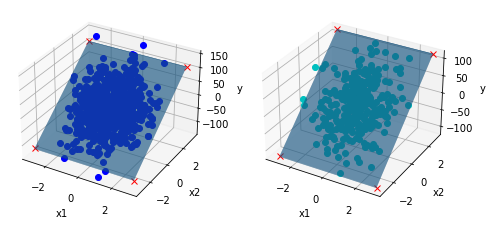

In [58]:
%matplotlib inline

# for interactive plot use widget
#%matplotlib widget

# sns.set_style("whitegrid", {'axes.grid' : False})

colors=['b', 'c', 'y', 'm', 'r']

fig, axs = plt.subplots(1,2,figsize=(8,4), subplot_kw={'projection': '3d'})

# train plot
axs[0].plot(x_train[:,0].numpy(), x_train[:,1].numpy(),y_train[:,0].numpy(), 'o', color='b')

axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].set_zlabel('y')

# regression plane
# xx,yy = np.meshgrid(data_points[:,0], data_points[:,1])
axs[0].plot(data_points[:,0], data_points[:,1], y_data[:,0], 'x', color='r')
axs[0].plot_surface(xx, yy, y_data, alpha=0.4)


# test plot
axs[1].plot(x_test[:,0].numpy(), x_test[:,1].numpy(),y_test[:,0].numpy(), 'o', color='c')

axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].set_zlabel('y')

# regression plane
axs[1].plot(data_points[:,0], data_points[:,1], y_data[:,0], 'x', color='r')
axs[1].plot_surface(xx, yy, y_data, alpha=0.4)


plt.show()